## Claude's Attempt

In [4]:
# Cell 1

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [5]:
# Cell 2

# Load the pickle file
with open('../../../data/train/combined_train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert to DataFrame if it's not already
if not isinstance(data, pd.DataFrame):
    df = pd.DataFrame(data)
else:
    df = data

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nFirst few rows:")
print(df.head())
print(f"\nScore statistics:")
print(df['score'].describe())

Dataset shape: (175272, 11)

Column types:
accession         object
scoreset          object
ensp              object
pos                int64
ref_long          object
alt_long          object
score            float64
ref_embedding     object
alt_embedding     object
biotype           object
consequences      object
dtype: object

First few rows:
                    accession                 scoreset               ensp  \
0  urn:mavedb:00000069-a-2#24  urn:mavedb:00000069-a-2  ENSP00000252519.3   
1  urn:mavedb:00000069-a-2#25  urn:mavedb:00000069-a-2  ENSP00000252519.3   
2  urn:mavedb:00000069-a-2#26  urn:mavedb:00000069-a-2  ENSP00000252519.3   
3  urn:mavedb:00000069-a-2#27  urn:mavedb:00000069-a-2  ENSP00000252519.3   
4  urn:mavedb:00000069-a-2#28  urn:mavedb:00000069-a-2  ENSP00000252519.3   

   pos ref_long alt_long     score  \
0   76      Gln      Ter -1.822141   
1   75      Glu      Ter -1.841030   
2   74      Lys      Ter -2.129071   
3   73      Leu      Ter -1.624920  

In [6]:
# Cell 2.1

# Filter out extreme outliers MORE aggressively
print(f"Original dataset size: {len(df)}")

# Keep only values within a reasonable range (95th percentile and below)
lower_percentile = df['score'].quantile(0.05)
upper_percentile = df['score'].quantile(0.95)

df_filtered = df[(df['score'] >= lower_percentile) & (df['score'] <= upper_percentile)].copy()

print(f"Filtered dataset size: {len(df_filtered)}")
print(f"Removed {len(df) - len(df_filtered)} outliers ({100*(len(df) - len(df_filtered))/len(df):.1f}%)")
print(f"New score range: {df_filtered['score'].min():.4f} to {df_filtered['score'].max():.4f}")
print(f"New score mean: {df_filtered['score'].mean():.4f}, std: {df_filtered['score'].std():.4f}")

# Use filtered dataframe
df = df_filtered

Original dataset size: 175272
Filtered dataset size: 157744
Removed 17528 outliers (10.0%)
New score range: -0.9663 to 7.5770
New score mean: 0.3224, std: 1.3957


In [7]:
# Cell 3

# Check the shape of embeddings
sample_ref_emb = df['ref_embedding'].iloc[0]
sample_alt_emb = df['alt_embedding'].iloc[0]

print(f"Reference embedding shape: {sample_ref_emb.shape}")
print(f"Alternative embedding shape: {sample_alt_emb.shape}")
print(f"Reference embedding type: {type(sample_ref_emb)}")

# Get embedding dimension
embedding_dim = sample_ref_emb.shape[0]
print(f"\nEmbedding dimension: {embedding_dim}")

Reference embedding shape: torch.Size([1152])
Alternative embedding shape: torch.Size([1152])
Reference embedding type: <class 'torch.Tensor'>

Embedding dimension: 1152


In [8]:
# Cell 3.1

# Let's see the actual score distribution
print("Raw score statistics:")
print(f"Min: {df['score'].min()}")
print(f"Max: {df['score'].max()}")
print(f"Mean: {df['score'].mean()}")
print(f"Std: {df['score'].std()}")
print(f"Median: {df['score'].median()}")

# Check for outliers
print(f"\nPercentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"{p}th: {df['score'].quantile(p/100):.4f}")

Raw score statistics:
Min: -0.966335320451526
Max: 7.577049845
Mean: 0.3224106484349853
Std: 1.3956767849940086
Median: -0.028166120099430002

Percentiles:
1th: -0.9302
5th: -0.8067
25th: -0.2970
50th: -0.0282
75th: 0.4024
95th: 3.1591
99th: 7.0869


In [9]:
# Cell 4

from sklearn.preprocessing import MinMaxScaler

class ProteinScoreDataset(Dataset):
    def __init__(self, dataframe, score_scaler=None, fit_scaler=False):
        self.df = dataframe.reset_index(drop=True)
        
        # Use MinMaxScaler to scale to [0, 1] - more stable than StandardScaler
        if fit_scaler:
            self.score_scaler = MinMaxScaler(feature_range=(0, 1))
            scores = self.df['score'].values.reshape(-1, 1)
            self.score_scaler.fit(scores)
        else:
            self.score_scaler = score_scaler
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get embeddings
        ref_embedding = row['ref_embedding']
        alt_embedding = row['alt_embedding']
        
        # Ensure embeddings are torch tensors
        if not isinstance(ref_embedding, torch.Tensor):
            ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
        else:
            ref_embedding = ref_embedding.float()
            
        if not isinstance(alt_embedding, torch.Tensor):
            alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
        else:
            alt_embedding = alt_embedding.float()
        
        # Concatenate embeddings
        combined_embedding = torch.cat([ref_embedding, alt_embedding], dim=0)
        
        # Normalize embeddings (L2 normalization)
        norm = torch.norm(combined_embedding)
        if norm > 0:
            combined_embedding = combined_embedding / norm
        
        # Get normalized score (will be in [0, 1] range)
        score = self.score_scaler.transform([[row['score']]])[0][0]
        score = torch.tensor(score, dtype=torch.float32)
        
        return combined_embedding, score

In [10]:
# Cell 5

# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create datasets with normalization
train_dataset = ProteinScoreDataset(train_df, fit_scaler=True)
val_dataset = ProteinScoreDataset(val_df, score_scaler=train_dataset.score_scaler, fit_scaler=False)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nScore normalization - Min: {train_dataset.score_scaler.data_min_[0]:.4f}, Max: {train_dataset.score_scaler.data_max_[0]:.4f}")
print(f"Scores will be scaled to range: [0, 1]")

Training set size: 126195
Validation set size: 31549

Score normalization - Min: -0.9663, Max: 7.5770
Scores will be scaled to range: [0, 1]


In [12]:

# Cell 6

class ScorePredictionNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.1):
        super(ScorePredictionNet, self).__init__()
        
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.LayerNorm(hidden_dim))  # LayerNorm instead of BatchNorm
            self.layers.append(nn.Tanh())  # Tanh instead of ReLU - bounded output
            self.layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        self.output = nn.Linear(prev_dim, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid to ensure [0, 1] output
        
        # Initialize weights conservatively
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=0.1)
                nn.init.zeros_(layer.bias)
        
        nn.init.xavier_uniform_(self.output.weight, gain=0.01)
        nn.init.zeros_(self.output.bias)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

# Initialize model
input_dim = embedding_dim * 2
model = ScorePredictionNet(input_dim)

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Using device: {device}")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: mps

Model architecture:
ScorePredictionNet(
  (layers): ModuleList(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (6): Tanh()
    (7): Dropout(p=0.1, inplace=False)
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 303,745


In [15]:
# Cell 7

# Training hyperparameters
learning_rate = 0.001  # Can be slightly higher with [0,1] range
num_epochs = 100
patience = 15

# MSE is fine for [0, 1] range
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Loss function: MSE (scores in [0, 1] range)")

Learning rate: 0.001
Number of epochs: 100
Loss function: MSE (scores in [0, 1] range)


In [16]:
# Cell 7.1

# Test a single batch to see where NaN originates
model.eval()
train_iter = iter(train_loader)
embeddings, scores = next(train_iter)

print("=" * 50)
print("DEBUGGING NaN ISSUE")
print("=" * 50)

# Check input data
print(f"\n1. INPUT DATA CHECK:")
print(f"   Embeddings shape: {embeddings.shape}")
print(f"   Embeddings contain NaN: {torch.isnan(embeddings).any()}")
print(f"   Embeddings contain Inf: {torch.isinf(embeddings).any()}")
print(f"   Embeddings min: {embeddings.min():.4f}, max: {embeddings.max():.4f}")
print(f"   Embeddings mean: {embeddings.mean():.4f}, std: {embeddings.std():.4f}")

print(f"\n   Scores shape: {scores.shape}")
print(f"   Scores contain NaN: {torch.isnan(scores).any()}")
print(f"   Scores contain Inf: {torch.isinf(scores).any()}")
print(f"   Scores min: {scores.min():.4f}, max: {scores.max():.4f}")
print(f"   Scores mean: {scores.mean():.4f}, std: {scores.std():.4f}")

# Check model forward pass
embeddings = embeddings.to(device)
scores = scores.to(device)

with torch.no_grad():
    predictions = model(embeddings)
    
print(f"\n2. MODEL OUTPUT CHECK:")
print(f"   Predictions contain NaN: {torch.isnan(predictions).any()}")
print(f"   Predictions contain Inf: {torch.isinf(predictions).any()}")
if not torch.isnan(predictions).any():
    print(f"   Predictions min: {predictions.min():.4f}, max: {predictions.max():.4f}")
    print(f"   Predictions mean: {predictions.mean():.4f}, std: {predictions.std():.4f}")

# Check loss calculation
loss = criterion(predictions, scores)
print(f"\n3. LOSS CHECK:")
print(f"   Loss value: {loss.item()}")
print(f"   Loss is NaN: {torch.isnan(loss)}")

# Check model weights
print(f"\n4. MODEL WEIGHTS CHECK:")
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"   NaN found in {name}")
    if torch.isinf(param).any():
        print(f"   Inf found in {name}")
    print(f"   {name}: min={param.min():.4f}, max={param.max():.4f}, mean={param.abs().mean():.4f}")
    if len(list(model.named_parameters())) > 10:  # Only print first few if many layers
        break

print("=" * 50)

DEBUGGING NaN ISSUE

1. INPUT DATA CHECK:
   Embeddings shape: torch.Size([64, 2304])
   Embeddings contain NaN: False
   Embeddings contain Inf: False
   Embeddings min: -0.5254, max: 0.3705
   Embeddings mean: -0.0003, std: 0.0208

   Scores shape: torch.Size([64])
   Scores contain NaN: False
   Scores contain Inf: False
   Scores min: 0.0007, max: 0.9826
   Scores mean: 0.1704, std: 0.2046

2. MODEL OUTPUT CHECK:
   Predictions contain NaN: False
   Predictions contain Inf: False
   Predictions min: 0.4971, max: 0.5035
   Predictions mean: 0.4998, std: 0.0017

3. LOSS CHECK:
   Loss value: 0.1497941017150879
   Loss is NaN: False

4. MODEL WEIGHTS CHECK:
   layers.0.weight: min=-0.0050, max=0.0050, mean=0.0025
   layers.0.bias: min=0.0000, max=0.0000, mean=0.0000
   layers.1.weight: min=1.0000, max=1.0000, mean=1.0000
   layers.1.bias: min=0.0000, max=0.0000, mean=0.0000
   layers.4.weight: min=-0.0177, max=0.0177, mean=0.0088
   layers.4.bias: min=0.0000, max=0.0000, mean=0.0000
 

In [17]:
# Cell 8

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print("Starting training...\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for embeddings, scores in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        embeddings = embeddings.to(device)
        scores = scores.to(device)
        
        # Check for NaN in inputs BEFORE forward pass
        if torch.isnan(embeddings).any() or torch.isinf(embeddings).any():
            print(f"\n⚠️  NaN/Inf in embeddings at batch {train_batches}, skipping...")
            continue
        
        if torch.isnan(scores).any() or torch.isinf(scores).any():
            print(f"\n⚠️  NaN/Inf in scores at batch {train_batches}, skipping...")
            continue
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(embeddings)
        
        # Check predictions before loss
        if torch.isnan(predictions).any() or torch.isinf(predictions).any():
            print(f"\n⚠️  NaN/Inf in predictions at batch {train_batches}, skipping...")
            continue
        
        loss = criterion(predictions, scores)
        
        # Check for NaN loss before backward
        if torch.isnan(loss):
            print(f"\n⚠️  NaN loss detected at epoch {epoch+1}, batch {train_batches}")
            print(f"   Predictions: min={predictions.min():.4f}, max={predictions.max():.4f}")
            print(f"   Scores: min={scores.min():.4f}, max={scores.max():.4f}")
            print("   Skipping this batch...")
            continue
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    if train_batches == 0:
        print("All batches had NaN loss. Stopping training.")
        break
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for embeddings, scores in val_loader:
            embeddings = embeddings.to(device)
            scores = scores.to(device)
            
            # Skip batches with NaN
            if torch.isnan(embeddings).any() or torch.isnan(scores).any():
                continue
            
            predictions = model(embeddings)
            
            if torch.isnan(predictions).any():
                continue
            
            loss = criterion(predictions, scores)
            
            if not torch.isnan(loss):
                val_loss += loss.item()
                val_batches += 1
    
    if val_batches == 0:
        print("All validation batches had NaN loss. Stopping training.")
        break
        
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Update learning rate scheduler
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print(f"  → New best model! (Val Loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print("\nTraining completed!")

Starting training...



Epoch 1/100 [Train]:  91%|█████████ | 1795/1972 [00:17<00:01, 113.75it/s]


⚠️  NaN/Inf in embeddings at batch 1780, skipping...


Epoch 1/100 [Train]: 100%|██████████| 1972/1972 [00:19<00:00, 99.26it/s] 


Epoch 1/100 - Train Loss: 0.0072, Val Loss: 0.0051
  → New best model! (Val Loss: 0.0051)


Epoch 2/100 [Train]:  30%|██▉       | 591/1972 [00:05<00:12, 112.91it/s]


⚠️  NaN/Inf in embeddings at batch 568, skipping...


Epoch 2/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.80it/s]


Epoch 2/100 - Train Loss: 0.0055, Val Loss: 0.0051


Epoch 3/100 [Train]:  29%|██▊       | 563/1972 [00:05<00:12, 113.48it/s]


⚠️  NaN/Inf in embeddings at batch 551, skipping...


Epoch 3/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 109.70it/s]


Epoch 3/100 - Train Loss: 0.0055, Val Loss: 0.0051


Epoch 4/100 [Train]:  63%|██████▎   | 1247/1972 [00:11<00:06, 113.07it/s]


⚠️  NaN/Inf in embeddings at batch 1224, skipping...


Epoch 4/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.95it/s]


Epoch 4/100 - Train Loss: 0.0055, Val Loss: 0.0051


Epoch 5/100 [Train]:  66%|██████▌   | 1295/1972 [00:11<00:06, 112.31it/s]


⚠️  NaN/Inf in embeddings at batch 1280, skipping...


Epoch 5/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.73it/s]


Epoch 5/100 - Train Loss: 0.0055, Val Loss: 0.0051
  → New best model! (Val Loss: 0.0051)


Epoch 6/100 [Train]:  60%|█████▉    | 1181/1972 [00:10<00:07, 112.50it/s]


⚠️  NaN/Inf in embeddings at batch 1168, skipping...


Epoch 6/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.22it/s]


Epoch 6/100 - Train Loss: 0.0055, Val Loss: 0.0050
  → New best model! (Val Loss: 0.0050)


Epoch 7/100 [Train]:  77%|███████▋  | 1518/1972 [00:13<00:04, 112.26it/s]


⚠️  NaN/Inf in embeddings at batch 1506, skipping...


Epoch 7/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.70it/s]


Epoch 7/100 - Train Loss: 0.0055, Val Loss: 0.0051


Epoch 8/100 [Train]:  47%|████▋     | 929/1972 [00:08<00:09, 111.61it/s]


⚠️  NaN/Inf in embeddings at batch 912, skipping...


Epoch 8/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.90it/s]


Epoch 8/100 - Train Loss: 0.0054, Val Loss: 0.0051


Epoch 9/100 [Train]:   8%|▊         | 152/1972 [00:01<00:16, 110.62it/s]


⚠️  NaN/Inf in embeddings at batch 133, skipping...


Epoch 9/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.52it/s]


Epoch 9/100 - Train Loss: 0.0054, Val Loss: 0.0050
  → New best model! (Val Loss: 0.0050)


Epoch 10/100 [Train]:  55%|█████▍    | 1075/1972 [00:09<00:07, 112.41it/s]


⚠️  NaN/Inf in embeddings at batch 1054, skipping...


Epoch 10/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 109.76it/s]


Epoch 10/100 - Train Loss: 0.0054, Val Loss: 0.0050


Epoch 11/100 [Train]:  41%|████▏     | 818/1972 [00:07<00:10, 106.80it/s]


⚠️  NaN/Inf in embeddings at batch 804, skipping...


Epoch 11/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 107.00it/s]


Epoch 11/100 - Train Loss: 0.0054, Val Loss: 0.0050


Epoch 12/100 [Train]:  65%|██████▍   | 1279/1972 [00:12<00:06, 106.37it/s]


⚠️  NaN/Inf in embeddings at batch 1265, skipping...


Epoch 12/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 105.38it/s]


Epoch 12/100 - Train Loss: 0.0054, Val Loss: 0.0050


Epoch 13/100 [Train]:  56%|█████▋    | 1113/1972 [00:10<00:07, 113.34it/s]


⚠️  NaN/Inf in embeddings at batch 1097, skipping...


Epoch 13/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 107.03it/s]


Epoch 13/100 - Train Loss: 0.0054, Val Loss: 0.0052


Epoch 14/100 [Train]:  84%|████████▍ | 1666/1972 [00:14<00:02, 112.66it/s]


⚠️  NaN/Inf in embeddings at batch 1650, skipping...


Epoch 14/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.37it/s]


Epoch 14/100 - Train Loss: 0.0054, Val Loss: 0.0051


Epoch 15/100 [Train]:  12%|█▏        | 230/1972 [00:02<00:16, 103.33it/s]


⚠️  NaN/Inf in embeddings at batch 215, skipping...


Epoch 15/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 103.82it/s]


Epoch 15/100 - Train Loss: 0.0054, Val Loss: 0.0050


Epoch 16/100 [Train]:  87%|████████▋ | 1711/1972 [00:16<00:02, 111.49it/s]


⚠️  NaN/Inf in embeddings at batch 1697, skipping...


Epoch 16/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 105.09it/s]


Epoch 16/100 - Train Loss: 0.0053, Val Loss: 0.0049
  → New best model! (Val Loss: 0.0049)


Epoch 17/100 [Train]:  69%|██████▉   | 1360/1972 [00:12<00:05, 111.83it/s]


⚠️  NaN/Inf in embeddings at batch 1339, skipping...


Epoch 17/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.17it/s]


Epoch 17/100 - Train Loss: 0.0053, Val Loss: 0.0049


Epoch 18/100 [Train]:  76%|███████▋  | 1504/1972 [00:14<00:04, 103.81it/s]


⚠️  NaN/Inf in embeddings at batch 1485, skipping...


Epoch 18/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 105.14it/s]


Epoch 18/100 - Train Loss: 0.0053, Val Loss: 0.0048
  → New best model! (Val Loss: 0.0048)


Epoch 19/100 [Train]:  19%|█▉        | 375/1972 [00:03<00:15, 106.01it/s]


⚠️  NaN/Inf in embeddings at batch 362, skipping...


Epoch 19/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 105.08it/s]


Epoch 19/100 - Train Loss: 0.0053, Val Loss: 0.0049


Epoch 20/100 [Train]:  42%|████▏     | 825/1972 [00:07<00:10, 105.00it/s]


⚠️  NaN/Inf in embeddings at batch 805, skipping...


Epoch 20/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 106.16it/s]


Epoch 20/100 - Train Loss: 0.0053, Val Loss: 0.0049


Epoch 21/100 [Train]:  76%|███████▋  | 1505/1972 [00:13<00:04, 114.91it/s]


⚠️  NaN/Inf in embeddings at batch 1486, skipping...


Epoch 21/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.99it/s]


Epoch 21/100 - Train Loss: 0.0053, Val Loss: 0.0049


Epoch 22/100 [Train]:  60%|█████▉    | 1175/1972 [00:10<00:06, 116.84it/s]


⚠️  NaN/Inf in embeddings at batch 1154, skipping...


Epoch 22/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.62it/s]


Epoch 22/100 - Train Loss: 0.0053, Val Loss: 0.0048


Epoch 23/100 [Train]:  55%|█████▍    | 1079/1972 [00:09<00:07, 112.81it/s]


⚠️  NaN/Inf in embeddings at batch 1061, skipping...


Epoch 23/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.37it/s]


Epoch 23/100 - Train Loss: 0.0053, Val Loss: 0.0049


Epoch 24/100 [Train]:  23%|██▎       | 447/1972 [00:04<00:13, 111.35it/s]


⚠️  NaN/Inf in embeddings at batch 425, skipping...


Epoch 24/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 113.58it/s]


Epoch 24/100 - Train Loss: 0.0053, Val Loss: 0.0048
  → New best model! (Val Loss: 0.0048)


Epoch 25/100 [Train]:  96%|█████████▌| 1896/1972 [00:16<00:00, 117.99it/s]


⚠️  NaN/Inf in embeddings at batch 1872, skipping...


Epoch 25/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.25it/s]


Epoch 25/100 - Train Loss: 0.0053, Val Loss: 0.0048


Epoch 26/100 [Train]:   5%|▍         | 94/1972 [00:00<00:16, 114.33it/s]


⚠️  NaN/Inf in embeddings at batch 76, skipping...


Epoch 26/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.80it/s]


Epoch 26/100 - Train Loss: 0.0053, Val Loss: 0.0049


Epoch 27/100 [Train]:  56%|█████▌    | 1099/1972 [00:09<00:07, 111.31it/s]


⚠️  NaN/Inf in embeddings at batch 1077, skipping...


Epoch 27/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.59it/s]


Epoch 27/100 - Train Loss: 0.0052, Val Loss: 0.0049


Epoch 28/100 [Train]:  43%|████▎     | 852/1972 [00:08<00:11, 100.18it/s]


⚠️  NaN/Inf in embeddings at batch 837, skipping...


Epoch 28/100 [Train]: 100%|██████████| 1972/1972 [00:19<00:00, 103.39it/s]


Epoch 28/100 - Train Loss: 0.0052, Val Loss: 0.0050


Epoch 29/100 [Train]:  56%|█████▌    | 1104/1972 [00:09<00:07, 115.25it/s]


⚠️  NaN/Inf in embeddings at batch 1082, skipping...


Epoch 29/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.57it/s]


Epoch 29/100 - Train Loss: 0.0052, Val Loss: 0.0049


Epoch 30/100 [Train]:  26%|██▋       | 519/1972 [00:04<00:12, 119.24it/s]


⚠️  NaN/Inf in embeddings at batch 498, skipping...


Epoch 30/100 [Train]: 100%|██████████| 1972/1972 [00:19<00:00, 102.78it/s]


Epoch 30/100 - Train Loss: 0.0052, Val Loss: 0.0048


Epoch 31/100 [Train]:  56%|█████▌    | 1099/1972 [00:11<00:08, 101.67it/s]


⚠️  NaN/Inf in embeddings at batch 1079, skipping...


Epoch 31/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 103.97it/s]


Epoch 31/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 32/100 [Train]:  67%|██████▋   | 1330/1972 [00:11<00:05, 114.21it/s]


⚠️  NaN/Inf in embeddings at batch 1312, skipping...


Epoch 32/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 114.12it/s]


Epoch 32/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 33/100 [Train]:  74%|███████▍  | 1463/1972 [00:14<00:04, 111.40it/s]


⚠️  NaN/Inf in embeddings at batch 1442, skipping...


Epoch 33/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 105.13it/s]


Epoch 33/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 34/100 [Train]:  70%|███████   | 1388/1972 [00:12<00:05, 111.79it/s]


⚠️  NaN/Inf in embeddings at batch 1371, skipping...


Epoch 34/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.81it/s]


Epoch 34/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 35/100 [Train]:  48%|████▊     | 946/1972 [00:08<00:09, 110.88it/s]


⚠️  NaN/Inf in embeddings at batch 933, skipping...


Epoch 35/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.45it/s]


Epoch 35/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 36/100 [Train]:   4%|▍         | 82/1972 [00:00<00:17, 111.13it/s]


⚠️  NaN/Inf in embeddings at batch 69, skipping...


Epoch 36/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 109.59it/s]


Epoch 36/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 37/100 [Train]:   9%|▉         | 185/1972 [00:01<00:16, 110.99it/s]


⚠️  NaN/Inf in embeddings at batch 167, skipping...


Epoch 37/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.71it/s]


Epoch 37/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 38/100 [Train]:  99%|█████████▊| 1947/1972 [00:17<00:00, 110.83it/s]


⚠️  NaN/Inf in embeddings at batch 1933, skipping...


Epoch 38/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.17it/s]


Epoch 38/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 39/100 [Train]:  44%|████▎     | 859/1972 [00:07<00:10, 110.83it/s]


⚠️  NaN/Inf in embeddings at batch 841, skipping...


Epoch 39/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 109.70it/s]


Epoch 39/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 40/100 [Train]:   3%|▎         | 68/1972 [00:00<00:17, 109.68it/s]


⚠️  NaN/Inf in embeddings at batch 51, skipping...


Epoch 40/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 111.10it/s]


Epoch 40/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 41/100 [Train]:  88%|████████▊ | 1733/1972 [00:15<00:02, 111.26it/s]


⚠️  NaN/Inf in embeddings at batch 1712, skipping...


Epoch 41/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.81it/s]


Epoch 41/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 42/100 [Train]:   9%|▉         | 174/1972 [00:01<00:16, 111.33it/s]


⚠️  NaN/Inf in embeddings at batch 163, skipping...


Epoch 42/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 109.87it/s]


Epoch 42/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 43/100 [Train]:  53%|█████▎    | 1048/1972 [00:09<00:08, 112.48it/s]


⚠️  NaN/Inf in embeddings at batch 1028, skipping...


Epoch 43/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.84it/s]


Epoch 43/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 44/100 [Train]:  21%|██        | 406/1972 [00:03<00:14, 111.15it/s]


⚠️  NaN/Inf in embeddings at batch 393, skipping...


Epoch 44/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.94it/s]


Epoch 44/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 45/100 [Train]:   7%|▋         | 129/1972 [00:01<00:16, 111.20it/s]


⚠️  NaN/Inf in embeddings at batch 108, skipping...


Epoch 45/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.77it/s]


Epoch 45/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 46/100 [Train]:  30%|██▉       | 584/1972 [00:05<00:12, 110.37it/s]


⚠️  NaN/Inf in embeddings at batch 565, skipping...


Epoch 46/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 109.74it/s]


Epoch 46/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 47/100 [Train]:  21%|██        | 407/1972 [00:03<00:14, 110.16it/s]


⚠️  NaN/Inf in embeddings at batch 390, skipping...


Epoch 47/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.39it/s]


Epoch 47/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 48/100 [Train]:  13%|█▎        | 251/1972 [00:02<00:14, 116.65it/s]


⚠️  NaN/Inf in embeddings at batch 228, skipping...


Epoch 48/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 112.29it/s]


Epoch 48/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 49/100 [Train]:  19%|█▉        | 371/1972 [00:03<00:13, 115.30it/s]


⚠️  NaN/Inf in embeddings at batch 348, skipping...


Epoch 49/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 113.82it/s]


Epoch 49/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 50/100 [Train]:  17%|█▋        | 336/1972 [00:02<00:13, 117.30it/s]


⚠️  NaN/Inf in embeddings at batch 319, skipping...


Epoch 50/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 118.14it/s]


Epoch 50/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 51/100 [Train]:  86%|████████▋ | 1704/1972 [00:14<00:02, 114.61it/s]


⚠️  NaN/Inf in embeddings at batch 1682, skipping...


Epoch 51/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.19it/s]


Epoch 51/100 - Train Loss: 0.0050, Val Loss: 0.0047


Epoch 52/100 [Train]:  25%|██▍       | 490/1972 [00:04<00:12, 114.94it/s]


⚠️  NaN/Inf in embeddings at batch 471, skipping...


Epoch 52/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 114.54it/s]


Epoch 52/100 - Train Loss: 0.0050, Val Loss: 0.0047


Epoch 53/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.45it/s]


⚠️  NaN/Inf in embeddings at batch 1950, skipping...


Epoch 53/100 - Train Loss: 0.0050, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 54/100 [Train]:  71%|███████   | 1403/1972 [00:12<00:04, 115.49it/s]


⚠️  NaN/Inf in embeddings at batch 1381, skipping...


Epoch 54/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.76it/s]


Epoch 54/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 55/100 [Train]:  66%|██████▌   | 1296/1972 [00:10<00:05, 121.32it/s]


⚠️  NaN/Inf in embeddings at batch 1276, skipping...


Epoch 55/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 117.24it/s]


Epoch 55/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 56/100 [Train]:  29%|██▊       | 563/1972 [00:04<00:12, 113.95it/s]


⚠️  NaN/Inf in embeddings at batch 551, skipping...


Epoch 56/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 114.27it/s]


Epoch 56/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 57/100 [Train]:  19%|█▉        | 383/1972 [00:03<00:13, 115.75it/s]


⚠️  NaN/Inf in embeddings at batch 359, skipping...


Epoch 57/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.20it/s]


Epoch 57/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 58/100 [Train]:  76%|███████▋  | 1508/1972 [00:13<00:04, 108.47it/s]


⚠️  NaN/Inf in embeddings at batch 1491, skipping...


Epoch 58/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 114.39it/s]


Epoch 58/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 59/100 [Train]:  58%|█████▊    | 1139/1972 [00:09<00:07, 116.74it/s]


⚠️  NaN/Inf in embeddings at batch 1119, skipping...


Epoch 59/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.94it/s]


Epoch 59/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 60/100 [Train]:  82%|████████▏ | 1609/1972 [00:13<00:03, 115.56it/s]


⚠️  NaN/Inf in embeddings at batch 1590, skipping...


Epoch 60/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.21it/s]


Epoch 60/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 61/100 [Train]:   3%|▎         | 60/1972 [00:00<00:16, 115.39it/s]


⚠️  NaN/Inf in embeddings at batch 42, skipping...


Epoch 61/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 114.92it/s]


Epoch 61/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 62/100 [Train]:  71%|███████   | 1393/1972 [00:12<00:04, 117.75it/s]


⚠️  NaN/Inf in embeddings at batch 1379, skipping...


Epoch 62/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.41it/s]


Epoch 62/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 63/100 [Train]:  67%|██████▋   | 1321/1972 [00:11<00:05, 117.31it/s]


⚠️  NaN/Inf in embeddings at batch 1303, skipping...


Epoch 63/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.36it/s]


Epoch 63/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 64/100 [Train]:  41%|████      | 807/1972 [00:06<00:09, 118.34it/s]


⚠️  NaN/Inf in embeddings at batch 793, skipping...


Epoch 64/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.85it/s]


Epoch 64/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 65/100 [Train]:  88%|████████▊ | 1729/1972 [00:14<00:02, 118.50it/s]


⚠️  NaN/Inf in embeddings at batch 1712, skipping...


Epoch 65/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.90it/s]


Epoch 65/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 66/100 [Train]:  27%|██▋       | 529/1972 [00:04<00:12, 117.67it/s]


⚠️  NaN/Inf in embeddings at batch 506, skipping...


Epoch 66/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.74it/s]


Epoch 66/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 67/100 [Train]:  51%|█████     | 1009/1972 [00:08<00:08, 116.93it/s]


⚠️  NaN/Inf in embeddings at batch 995, skipping...


Epoch 67/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.58it/s]


Epoch 67/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 68/100 [Train]:  67%|██████▋   | 1320/1972 [00:11<00:05, 116.71it/s]


⚠️  NaN/Inf in embeddings at batch 1305, skipping...


Epoch 68/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.34it/s]


Epoch 68/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 69/100 [Train]:  80%|███████▉  | 1576/1972 [00:13<00:03, 118.69it/s]


⚠️  NaN/Inf in embeddings at batch 1552, skipping...


Epoch 69/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.71it/s]


Epoch 69/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 70/100 [Train]:  51%|█████     | 997/1972 [00:08<00:08, 117.50it/s]


⚠️  NaN/Inf in embeddings at batch 980, skipping...


Epoch 70/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.87it/s]


Epoch 70/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 71/100 [Train]:  54%|█████▎    | 1056/1972 [00:09<00:07, 115.97it/s]


⚠️  NaN/Inf in embeddings at batch 1043, skipping...


Epoch 71/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.08it/s]


Epoch 71/100 - Train Loss: 0.0049, Val Loss: 0.0047


Epoch 72/100 [Train]:  59%|█████▉    | 1162/1972 [00:09<00:07, 112.96it/s]


⚠️  NaN/Inf in embeddings at batch 1139, skipping...


Epoch 72/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.69it/s]


Epoch 72/100 - Train Loss: 0.0050, Val Loss: 0.0047


Epoch 73/100 [Train]:  66%|██████▌   | 1295/1972 [00:10<00:05, 118.30it/s]


⚠️  NaN/Inf in embeddings at batch 1275, skipping...


Epoch 73/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 117.36it/s]


Epoch 73/100 - Train Loss: 0.0049, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 74/100 [Train]:   8%|▊         | 153/1972 [00:01<00:15, 115.28it/s]


⚠️  NaN/Inf in embeddings at batch 132, skipping...


Epoch 74/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.14it/s]


Epoch 74/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 75/100 [Train]:  45%|████▌     | 888/1972 [00:07<00:09, 117.63it/s]


⚠️  NaN/Inf in embeddings at batch 873, skipping...


Epoch 75/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.00it/s]


Epoch 75/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 76/100 [Train]:  28%|██▊       | 551/1972 [00:04<00:12, 115.91it/s]


⚠️  NaN/Inf in embeddings at batch 536, skipping...


Epoch 76/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.32it/s]


Epoch 76/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 77/100 [Train]:  18%|█▊        | 348/1972 [00:03<00:13, 116.17it/s]


⚠️  NaN/Inf in embeddings at batch 331, skipping...


Epoch 77/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 114.51it/s]


Epoch 77/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 78/100 [Train]:   6%|▌         | 119/1972 [00:01<00:16, 114.05it/s]


⚠️  NaN/Inf in embeddings at batch 104, skipping...


Epoch 78/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 114.71it/s]


Epoch 78/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 79/100 [Train]:  48%|████▊     | 947/1972 [00:08<00:08, 118.85it/s]


⚠️  NaN/Inf in embeddings at batch 926, skipping...


Epoch 79/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.60it/s]


Epoch 79/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 80/100 [Train]:  62%|██████▏   | 1226/1972 [00:10<00:06, 118.08it/s]


⚠️  NaN/Inf in embeddings at batch 1203, skipping...


Epoch 80/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 117.13it/s]


Epoch 80/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 81/100 [Train]:  95%|█████████▍| 1873/1972 [00:16<00:00, 116.94it/s]


⚠️  NaN/Inf in embeddings at batch 1858, skipping...


Epoch 81/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.63it/s]


Epoch 81/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 82/100 [Train]:  97%|█████████▋| 1919/1972 [00:16<00:00, 115.87it/s]


⚠️  NaN/Inf in embeddings at batch 1902, skipping...


Epoch 82/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.14it/s]


Epoch 82/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 83/100 [Train]:  39%|███▉      | 768/1972 [00:06<00:10, 117.14it/s]


⚠️  NaN/Inf in embeddings at batch 747, skipping...


Epoch 83/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.29it/s]


Epoch 83/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 84/100 [Train]:  41%|████▏     | 816/1972 [00:07<00:09, 117.85it/s]


⚠️  NaN/Inf in embeddings at batch 802, skipping...


Epoch 84/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.20it/s]


Epoch 84/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 85/100 [Train]:  71%|███████   | 1393/1972 [00:11<00:04, 116.71it/s]


⚠️  NaN/Inf in embeddings at batch 1378, skipping...


Epoch 85/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.42it/s]


Epoch 85/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 86/100 [Train]:  47%|████▋     | 926/1972 [00:07<00:08, 116.22it/s]


⚠️  NaN/Inf in embeddings at batch 904, skipping...


Epoch 86/100 [Train]: 100%|██████████| 1972/1972 [00:16<00:00, 116.50it/s]


Epoch 86/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 87/100 [Train]:  38%|███▊      | 756/1972 [00:06<00:10, 118.67it/s]


⚠️  NaN/Inf in embeddings at batch 733, skipping...


Epoch 87/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 115.33it/s]


Epoch 87/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 88/100 [Train]:  46%|████▌     | 904/1972 [00:09<00:10, 99.67it/s] 


⚠️  NaN/Inf in embeddings at batch 886, skipping...


Epoch 88/100 [Train]: 100%|██████████| 1972/1972 [00:19<00:00, 103.31it/s]


Epoch 88/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 89/100 [Train]:  31%|███       | 604/1972 [00:05<00:12, 110.91it/s]


⚠️  NaN/Inf in embeddings at batch 581, skipping...


Epoch 89/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 109.74it/s]


Epoch 89/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 90/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.05it/s]



⚠️  NaN/Inf in embeddings at batch 1954, skipping...
Epoch 90/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 91/100 [Train]:  42%|████▏     | 836/1972 [00:07<00:10, 111.15it/s]


⚠️  NaN/Inf in embeddings at batch 818, skipping...


Epoch 91/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 109.02it/s]


Epoch 91/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 92/100 [Train]:  55%|█████▍    | 1075/1972 [00:09<00:08, 109.12it/s]


⚠️  NaN/Inf in embeddings at batch 1055, skipping...


Epoch 92/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 109.14it/s]


Epoch 92/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 93/100 [Train]:  76%|███████▋  | 1505/1972 [00:13<00:04, 109.50it/s]


⚠️  NaN/Inf in embeddings at batch 1493, skipping...


Epoch 93/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 108.77it/s]


Epoch 93/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 94/100 [Train]:  60%|██████    | 1190/1972 [00:10<00:07, 110.49it/s]


⚠️  NaN/Inf in embeddings at batch 1175, skipping...


Epoch 94/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 109.48it/s]


Epoch 94/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 95/100 [Train]:  98%|█████████▊| 1941/1972 [00:17<00:00, 110.72it/s]


⚠️  NaN/Inf in embeddings at batch 1920, skipping...


Epoch 95/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.37it/s]


Epoch 95/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 96/100 [Train]:  61%|██████    | 1202/1972 [00:11<00:06, 110.42it/s]


⚠️  NaN/Inf in embeddings at batch 1191, skipping...


Epoch 96/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 108.48it/s]


Epoch 96/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 97/100 [Train]:  66%|██████▌   | 1304/1972 [00:11<00:05, 111.49it/s]


⚠️  NaN/Inf in embeddings at batch 1289, skipping...


Epoch 97/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 109.47it/s]


Epoch 97/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 98/100 [Train]:  63%|██████▎   | 1235/1972 [00:11<00:06, 110.77it/s]


⚠️  NaN/Inf in embeddings at batch 1222, skipping...


Epoch 98/100 [Train]: 100%|██████████| 1972/1972 [00:17<00:00, 110.03it/s]


Epoch 98/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 99/100 [Train]:  46%|████▌     | 901/1972 [00:08<00:09, 109.67it/s]


⚠️  NaN/Inf in embeddings at batch 881, skipping...


Epoch 99/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 108.80it/s]


Epoch 99/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 100/100 [Train]:  95%|█████████▌| 1874/1972 [00:17<00:00, 110.67it/s]


⚠️  NaN/Inf in embeddings at batch 1852, skipping...


Epoch 100/100 [Train]: 100%|██████████| 1972/1972 [00:18<00:00, 109.43it/s]


Epoch 100/100 - Train Loss: 0.0048, Val Loss: 0.0045

Training completed!


In [18]:
# Cell 9

# Model is already trained, just set to eval mode
model.eval()

# Get predictions for validation set
val_predictions = []
val_actuals = []
val_predictions_normalized = []
val_actuals_normalized = []

with torch.no_grad():
    for embeddings, scores in val_loader:
        embeddings = embeddings.to(device)
        scores_normalized = scores.to(device)
        predictions_normalized = model(embeddings)
        
        # Store normalized predictions and actuals
        val_predictions_normalized.extend(predictions_normalized.cpu().numpy())
        val_actuals_normalized.extend(scores_normalized.cpu().numpy())

# Convert to arrays
val_predictions_normalized = np.array(val_predictions_normalized).reshape(-1, 1)
val_actuals_normalized = np.array(val_actuals_normalized).reshape(-1, 1)

# Inverse transform to get original scale
val_predictions = train_dataset.score_scaler.inverse_transform(val_predictions_normalized).flatten()
val_actuals = train_dataset.score_scaler.inverse_transform(val_actuals_normalized).flatten()

# Calculate metrics on original scale
mse = mean_squared_error(val_actuals, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actuals, val_predictions)
r2 = r2_score(val_actuals, val_predictions)

print("=" * 50)
print("VALIDATION SET RESULTS (Original Scale)")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)

# Also show normalized metrics for reference
mse_norm = mean_squared_error(val_actuals_normalized, val_predictions_normalized)
print(f"\nNormalized MSE: {mse_norm:.4f}")

VALIDATION SET RESULTS (Original Scale)
Mean Squared Error (MSE):  0.3304
Root Mean Squared Error (RMSE): 0.5748
Mean Absolute Error (MAE): 0.3217
R² Score: 0.8231

Normalized MSE: 0.0045


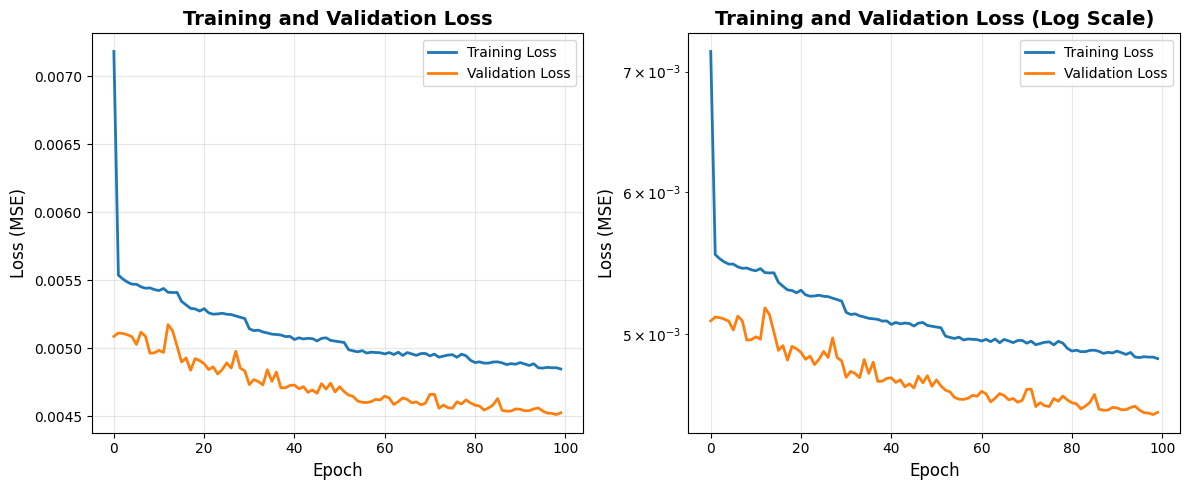

In [19]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

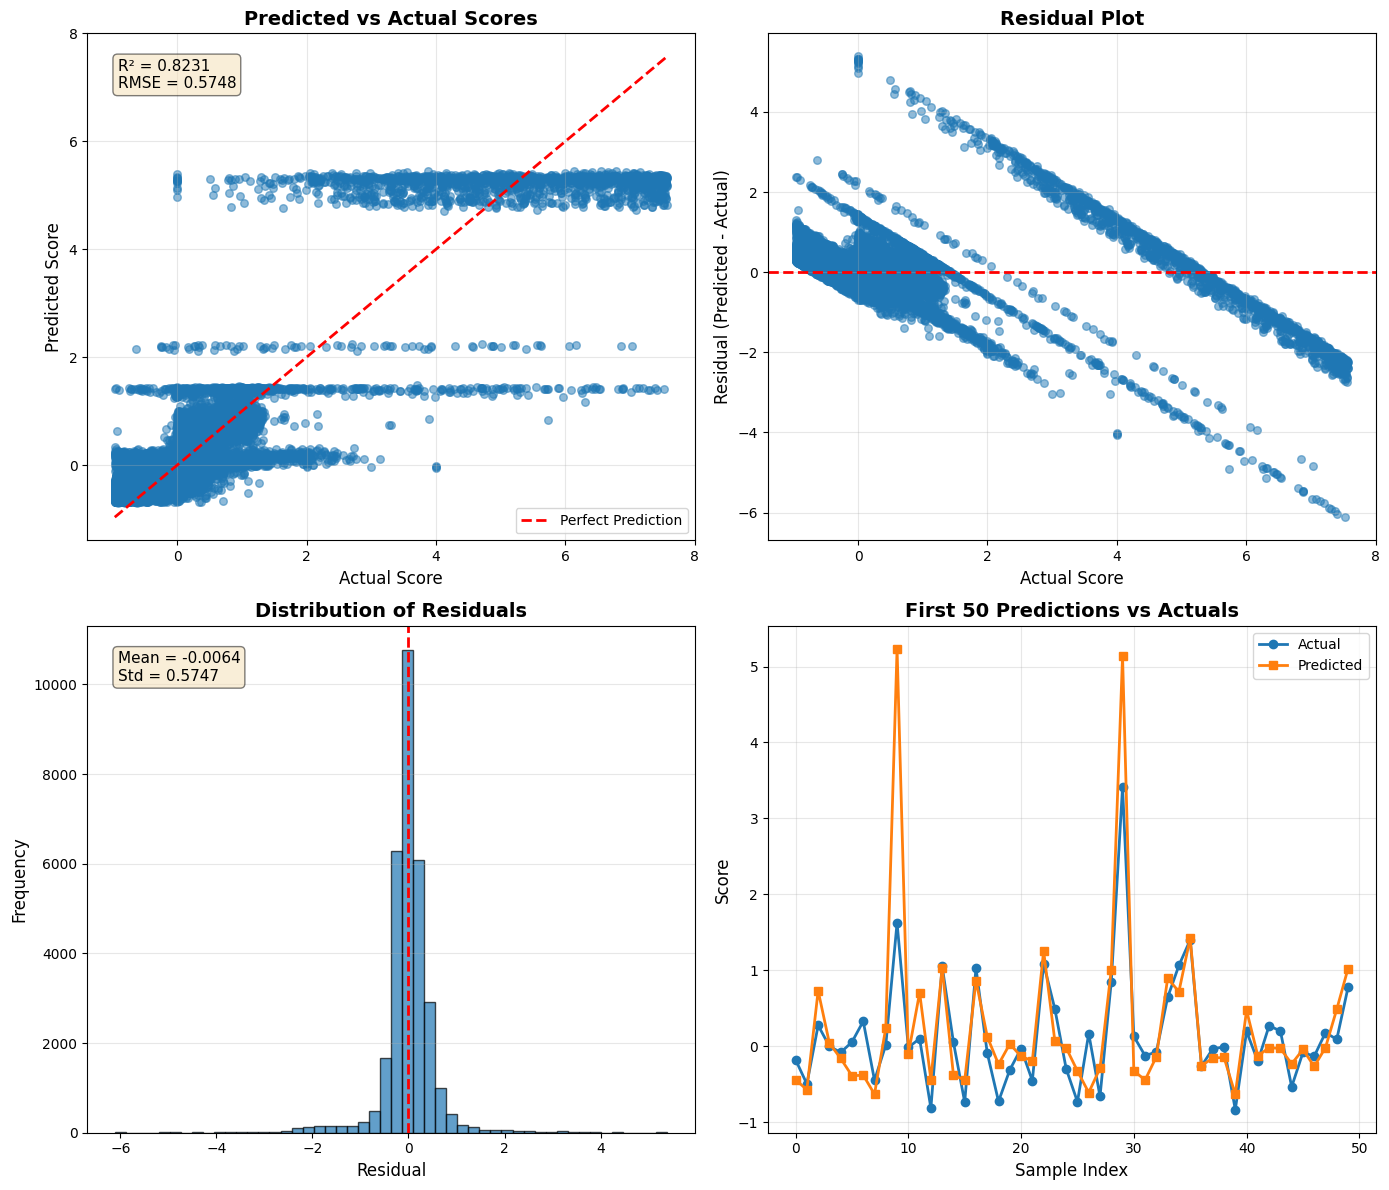


Visualizations saved to ../output/


In [20]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scatter plot: Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(val_actuals, val_predictions, alpha=0.5, s=30)
ax1.plot([val_actuals.min(), val_actuals.max()], 
         [val_actuals.min(), val_actuals.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Score', fontsize=12)
ax1.set_ylabel('Predicted Score', fontsize=12)
ax1.set_title('Predicted vs Actual Scores', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}', 
         transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residual plot
ax2 = axes[0, 1]
residuals = val_predictions - val_actuals
ax2.scatter(val_actuals, residuals, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Actual Score', fontsize=12)
ax2.set_ylabel('Residual (Predicted - Actual)', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Distribution of residuals
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residual', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.text(0.05, 0.95, f'Mean = {residuals.mean():.4f}\nStd = {residuals.std():.4f}', 
         transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Comparison of first N predictions
ax4 = axes[1, 1]
n_samples = min(50, len(val_actuals))
indices = np.arange(n_samples)
ax4.plot(indices, val_actuals[:n_samples], 'o-', label='Actual', linewidth=2, markersize=6)
ax4.plot(indices, val_predictions[:n_samples], 's-', label='Predicted', linewidth=2, markersize=6)
ax4.set_xlabel('Sample Index', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title(f'First {n_samples} Predictions vs Actuals', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualizations saved to ../output/")

In [21]:
# Error analysis
errors = np.abs(residuals)
percentiles = [50, 75, 90, 95, 99]

print("\n" + "=" * 50)
print("ERROR ANALYSIS")
print("=" * 50)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Median Absolute Error: {np.median(errors):.4f}")
print(f"Max Absolute Error: {np.max(errors):.4f}")
print(f"\nError Percentiles:")
for p in percentiles:
    print(f"  {p}th percentile: {np.percentile(errors, p):.4f}")

# Find worst predictions
worst_indices = np.argsort(errors)[-10:][::-1]
print(f"\n{'=' * 50}")
print("TOP 10 WORST PREDICTIONS")
print("=" * 50)
print(f"{'Index':<8} {'Actual':<12} {'Predicted':<12} {'Error':<12}")
print("-" * 50)
for idx in worst_indices:
    print(f"{idx:<8} {val_actuals[idx]:<12.4f} {val_predictions[idx]:<12.4f} {errors[idx]:<12.4f}")


ERROR ANALYSIS
Mean Absolute Error: 0.3217
Median Absolute Error: 0.1881
Max Absolute Error: 6.1160

Error Percentiles:
  50th percentile: 0.1881
  75th percentile: 0.3606
  90th percentile: 0.6522
  95th percentile: 1.0966
  99th percentile: 2.3768

TOP 10 WORST PREDICTIONS
Index    Actual       Predicted    Error       
--------------------------------------------------
5028     7.5321       1.4161       6.1160      
13342    7.4105       1.3834       6.0271      
16595    7.3799       1.4246       5.9553      
17516    7.3056       1.3935       5.9121      
4979     7.2840       1.3913       5.8927      
2972     7.2013       1.4319       5.7694      
9726     7.1375       1.4206       5.7169      
28278    7.0852       1.4214       5.6638      
26246    7.0129       1.3586       5.6543      
9115     6.8847       1.4054       5.4793      


In [24]:
# Code to generate file to submit to kaggle

# data at ../../../data/test/combined_test_data.pkl

# Load test data
print("Loading test data...")
with open('../../../data/test/combined_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Convert to DataFrame if needed
if not isinstance(test_data, pd.DataFrame):
    test_df = pd.DataFrame(test_data)
else:
    test_df = test_data

print(f"Test dataset shape: {test_df.shape}")
print(f"Test columns: {test_df.columns.tolist()}")

# Create test dataset (no scores, so we'll pass dummy scores)
class TestProteinScoreDataset(Dataset):
    def __init__(self, dataframe, score_scaler):
        self.df = dataframe.reset_index(drop=True)
        self.score_scaler = score_scaler
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get embeddings
        ref_embedding = row['ref_embedding']
        alt_embedding = row['alt_embedding']
        
        # Ensure embeddings are torch tensors
        if not isinstance(ref_embedding, torch.Tensor):
            ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
        else:
            ref_embedding = ref_embedding.float()
            
        if not isinstance(alt_embedding, torch.Tensor):
            alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
        else:
            alt_embedding = alt_embedding.float()
        
        # Concatenate embeddings
        combined_embedding = torch.cat([ref_embedding, alt_embedding], dim=0)
        
        # Normalize embeddings (L2 normalization)
        norm = torch.norm(combined_embedding)
        if norm > 0:
            combined_embedding = combined_embedding / norm
        
        return combined_embedding, row['accession']

# Create test dataset and dataloader
test_dataset = TestProteinScoreDataset(test_df, train_dataset.score_scaler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"\nGenerating predictions for {len(test_df)} test samples...")

# Generate predictions
model.eval()
predictions_normalized = []
accessions = []

with torch.no_grad():
    for embeddings, batch_accessions in tqdm(test_loader, desc="Predicting"):
        embeddings = embeddings.to(device)
        
        # Skip if NaN in embeddings
        if torch.isnan(embeddings).any() or torch.isinf(embeddings).any():
            # Use median prediction for problematic samples
            preds = torch.full((embeddings.size(0),), 0.5, device=device)
        else:
            preds = model(embeddings)
            
            # Replace any NaN predictions with median
            if torch.isnan(preds).any():
                preds = torch.where(torch.isnan(preds), torch.tensor(0.5, device=device), preds)
        
        predictions_normalized.extend(preds.cpu().numpy())
        accessions.extend(batch_accessions)

# Convert to array and denormalize
predictions_normalized = np.array(predictions_normalized).reshape(-1, 1)
predictions_denormalized = train_dataset.score_scaler.inverse_transform(predictions_normalized).flatten()

# Create submission dataframe with exact format from example
submission_df = pd.DataFrame({
    'accession': accessions,
    'score': predictions_denormalized  # Second column with empty header name
})

# Save to CSV
output_path = './output.csv'
submission_df.to_csv(output_path, index=False)

print(f"\n✓ Predictions saved to {output_path}")
print(f"\nSubmission file preview:")
print(submission_df.head(10))
print(f"\nPrediction statistics:")
print(f"Min: {predictions_denormalized.min():.4f}")
print(f"Max: {predictions_denormalized.max():.4f}")
print(f"Mean: {predictions_denormalized.mean():.4f}")
print(f"Median: {np.median(predictions_denormalized):.4f}")


Loading test data...
Test dataset shape: (118421, 10)
Test columns: ['accession', 'scoreset', 'ensp', 'pos', 'ref_long', 'alt_long', 'ref_embedding', 'alt_embedding', 'biotype', 'consequences']

Generating predictions for 118421 test samples...


Predicting: 100%|██████████| 1851/1851 [00:05<00:00, 316.53it/s]



✓ Predictions saved to ./output.csv

Submission file preview:
                    accession     score
0   urn:mavedb:00000069-a-2#1 -0.662086
1   urn:mavedb:00000069-a-2#2 -0.660307
2   urn:mavedb:00000069-a-2#3 -0.645050
3   urn:mavedb:00000069-a-2#4 -0.642727
4   urn:mavedb:00000069-a-2#5 -0.648489
5   urn:mavedb:00000069-a-2#6 -0.611929
6   urn:mavedb:00000069-a-2#7 -0.594484
7   urn:mavedb:00000069-a-2#8 -0.584665
8   urn:mavedb:00000069-a-2#9 -0.593760
9  urn:mavedb:00000069-a-2#10 -0.604224

Prediction statistics:
Min: -0.6955
Max: 5.4550
Mean: 0.5310
Median: -0.0413
